# E-commerce User Behavior and Category Operation Insights
Understanding user purchase dynamics and optimizing category-level growth strategies

# Business Background
This analysis covers data from November 25 to December 3, encompassing both weekends and the pre–“Double 12” shopping season.
During this promotional period, user interactions and product engagement behaviors exhibit distinctive temporal patterns.
The purpose of this project is to support data-driven operational decisions by exploring user behavior dynamics and category performance during this critical sales phase, providing actionable insights for future campaign planning and assortment optimization.


# Data Processing

## Data source
The dataset used in this project is from Aliyun：https://tianchi.aliyun.com/dataset/649

### Data Description：
The dataset **UserBehavior.csv** contains complete interaction records of approximately 1 million randomly sampled users between November 25 and December 3, 2017.

The dataset follows a structure as the following fields:

* **user_id**: Unique user identifier

* **product_id**: Unique item identifier

* **category_id**: Category identifier of the item

* **action_type**: Type of behavior (pv / cart / fav / buy)

* **event_timestamp**: Unix timestamp of the behavior


There are four main action types:

**pv** – Viewing a product detail page (equivalent to a click)

**cart** – Adding a product to the shopping cart

**fav** – Adding a product to favorites

**buy** – Completing a purchase

The dataset is large-scale and highly representative, containing nearly one hundred million behavioral records across multiple user and product dimensions. The main data metrics are as follows:

**Number of Users**: 987,994

**Number of Items**: 4,162,024

**Number of Categories**: 9,439

**Total Behavioral Records**: 100,150,807



## Data cleaning


Due to hardware limitations and to prevent performance issues during processing, only the first 3,000,000 rows of the original dataset were selected as a sample for analysis.

The python code is as follows:

In [ ]:
import pandas as pd
import time

start_time = time.time()

input_file = r'../UserBehavior.csv'
output_file = r'../UserBehavior_.csv'

n_rows = 3000000

# Read the first 3 million rows from the original CSV
df = pd.read_csv(input_file, nrows=n_rows)

# Save the subset to a new CSV file
df.to_csv(output_file, index=False)

elapsed_time = time.time() - start_time
print(f"Data processing completed! Time elapsed: {elapsed_time:.2f} seconds.")
print(f"Successfully saved {len(df):,} rows to the new file.")


In [ ]:
# Define column names (avoid SQL keywords, better for database operations)
column_names = [
    'user_id',          # User ID
    'product_id',       # Product ID
    'category_id',      # Product Category ID
    'action_type',      # Action Type
    'event_timestamp'   # Event Timestamp
]

# Read CSV file and specify column names
df = pd.read_csv(
    r'../UserBehavior_.csv',
    names=column_names
)

# Convert timestamp to datetime format (UTC+8 timezone)
df['times'] = pd.to_datetime(df['event_timestamp'], unit='s') + pd.Timedelta(hours=8)

# Extract date and time information (avoid SQL keywords)
df['dates'] = df['times'].dt.date       # Event date
df['hours'] = df['times'].dt.hour       # Event hour
df['weekdays'] = df['times'].dt.day_name()  # Event weekday

print("Basic dataset information:")
df.info()

# Get dataset dimensions
rows, columns = df.shape

if rows > 0:
    print(f"\nThe dataset contains {rows} records and {columns} fields")

    # Preview first few rows (using SQL-safe column names)
    print("\nFirst few rows of the dataset:")
    print(df[['user_id', 'product_id', 'action_type', 'times', 'dates', 'hours', 'weekdays']].head().to_csv(sep='\t', na_rep='nan'))

# Define date range
start_date = pd.to_datetime('2017-11-25 00:00:00')
end_date = pd.to_datetime('2017-12-03 23:59:59')

# Filter data within the date range
original_rows = len(df)
df = df[(df['times'] >= start_date) & (df['times'] <= end_date)]
filtered_rows = len(df)
filtered_percentage = (filtered_rows / original_rows) * 100 if original_rows > 0 else 0

print("\nFiltered dataset information:")
df.info()

# Check for missing values
print("\nMissing values summary:")
print(df.isnull().sum())

# Check for duplicates and remove them
print("\nDuplicate records summary:")
duplicate_count = df.duplicated().sum()
print(f"Number of duplicates before removal: {duplicate_count}")
df = df.drop_duplicates()
print(f"Number of duplicates after removal: {df.duplicated().sum()}")

# Save the processed dataset (SQL-safe column names)
df.to_csv(r'../UserBehavior_A.csv', index=False)


## Metric Definitions
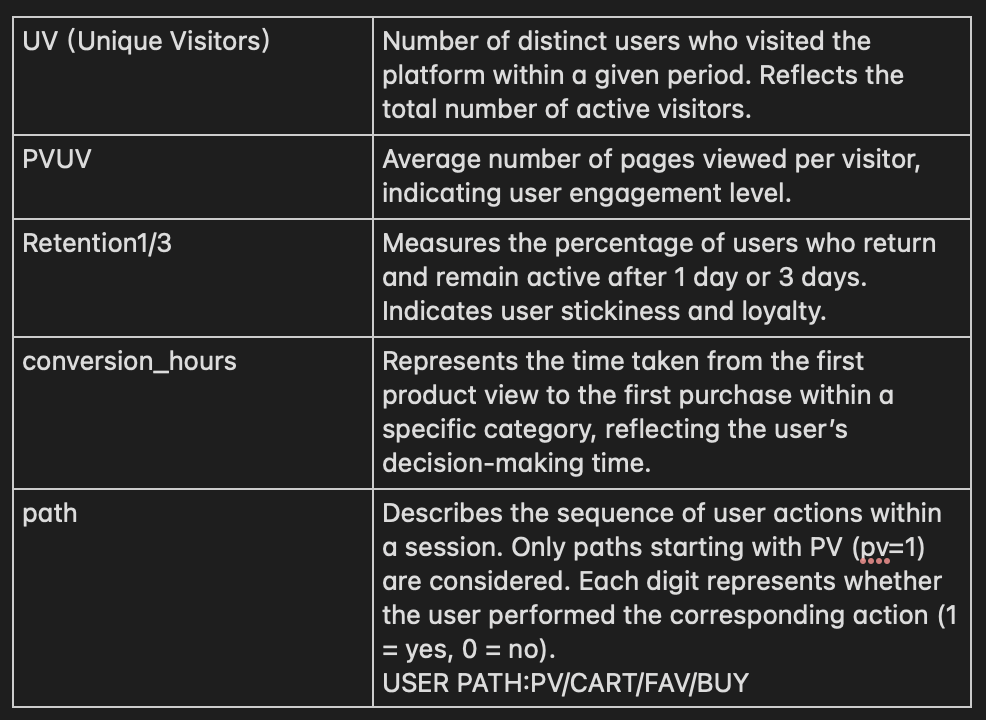


# Processing Logic
：How the metric is computed from the raw data.

(1)Table: **df_pv_uv**

The table **df_pv_uv** is generated by aggregating user activity data from the source table **userbehavior**. For each date, the process calculates:

PV (Page Views): The total number of records where **action_type = 'pv'**.

UV (Unique Visitors): The number of distinct **user_id** values.

PVUV Ratio: The ratio of page views to unique visitors, rounded to two decimal places.

The results are grouped by dates and inserted into the target table **df_pv_uv**.


(2)Table:**df_retention_1**,**df_retention_3**

User retention is calculated based on distinct user activity records from **userbehavior**.

One-day retention: The proportion of users who were active again one day after their initial activity (**INTERVAL 1 DAY**).

Three-day retention: The proportion of users who returned three days later (**INTERVAL 3 DAY**).

Results are grouped by date and stored in **df_retention_1** and **df_retention_3**, respectively.


(3)Table:**df_timeseries**

The table **df_timeseries** is generated by aggregating user actions from **userbehavior** on a time-series basis.
For each date and hour, the process counts the occurrences of the four user behaviors (PV, CART, FAV, BUY).
The results are grouped by dates and hours, ordered chronologically, and stored in **df_timeseries**.

(4)Table:**path**(User Behavior Path)

The table **path** is generated based on individual user activity records from **userbehavior**.

Data is grouped by **user_id** and **category_id** to determine whether each user performed the four types of actions(PV, CART, FAV, BUY).
Each action is converted into a binary indicator (1 if the action occurred, 0 otherwise), and the combination of these indicators forms the user’s behavior path.

Since the dataset starts on 2017-11-25, some users may appear to have made a purchase without any prior browsing record (e.g., “/-/-/-/BUY”). These cases are excluded from the analysis, as earlier behaviors may have occurred before the data collection period.
Only users with browsing activity are retained for the study.

(5)Table:**funnel**(Funnel Model)

The table **funnel** is created to measure user conversion along the behavior path **PV → CART/FAV → BUY**.
For each date, the number of distinct users performing each action type is counted from **userbehavior**:

**pv_num**: users who viewed items

**cart_fav_num**: users who either added items to the cart or marked them as favorites

**buy_num**: users who completed a purchase

The results are grouped by date to represent the daily funnel progression of user engagement and conversion.

(6)Table:**df_rfc**(RFC Model for User Segmentation)

Since the dataset does not include transaction amount information, the traditional RFM model (Recency, Frequency, Monetary) is adapted into an RFC model, where the Monetary dimension is replaced with the combined count of “Cart” and “Favorite” actions.

The model evaluates users along three behavioral dimensions:

* R (Recency): The most recent purchase date.

A higher score indicates more recent activity.

* F (Frequency): The total number of purchase actions.

A higher score means more frequent purchases.

* C (Cart & Favorite): The total number of cart additions and favorites.

A higher score represents stronger interest and engagement.

Each user receives a score for R, F, and C based on predefined thresholds.
Average scores (**avg_r**, **avg_f**, **avg_c**) are then calculated across all users.
Users are classified into eight categories according to whether their R, F, and C scores are above or below these averages.


| **Category**         | **Condition**                   | **Description**                                                                           |
| -------------------- | ------------------------------- | ----------------------------------------------------------------------------------------- |
| **Premium Users** | F ≥ avg_f, R ≥ avg_r, C ≥ avg_c | Users who purchase frequently, recently, and show strong interest. Core target customers. |
| **Potential Users**  | F ≥ avg_f, R ≥ avg_r, C < avg_c | Recently active frequent buyers, but with weaker engagement (few cart/fav actions).       |
| **Active Users**     | F ≥ avg_f, R < avg_r, C ≥ avg_c | Users who show high interest and engagement but whose last purchase is less recent.       |
| **Retained Users**     | F ≥ avg_f, R < avg_r, C < avg_c | Loyal but less recently active customers.                                                 |
| **Growing Users** | F < avg_f, R ≥ avg_r, C ≥ avg_c | New or growing users showing recent activity and high engagement potential.               |
| **New Users**        | F < avg_f, R ≥ avg_r, C < avg_c | Recently joined users with limited purchases and engagement.                              |
| **Interested Users** | F < avg_f, R < avg_r, C ≥ avg_c | Users with low purchase frequency but strong browsing or engagement behavior.             |
| **Churn-Risk Users**    | F < avg_f, R < avg_r, C < avg_c | Inactive users with low purchase frequency and engagement; retention efforts recommended. |


(7)Table:**product_buy_hot**, **category_buy_hot**(Hot Products and Categories)

The purpose of this step is to identify the most popular products and categories based on purchase behavior.

The table **product_buy_hot** records the top 1,000 products with the highest number of purchase actions.

The table **category_buy_hot** records the top 100 categories ranked by total purchase counts.

Both datasets are generated by aggregating the number of buy actions in **userbehavior**, grouping by **product_id** and **category_id**, and sorting the results in descending order of purchase volume.

(8)Table:**category_pv_buy_time**

The table **category_pv_buy_time** measures the decision time for each user on each category, defined as the time between the first page view (PV) and the first purchase (BUY).

Filter Users with Purchases: Only consider user-category pairs where a purchase has occurred.

First PV and First BUY:

For each user-category pair, calculate the timestamp of the first PV.

Calculate the timestamp of the first BUY.

User-Level Conversion Time: Compute the time difference between the first PV and first BUY in seconds, keeping only cases where the first view occurs before the purchase.

Category-Level Average: Aggregate user-level conversion times to calculate the average conversion time for each category, both in seconds and hours.

Final Table: For each user-category pair, record:

* User ID and category ID

* First PV and first BUY timestamps

* Conversion time in hours

* Average conversion time for the category

* Deviation from the category average

The table is filtered to include only user activity after 2017-11-25 and is ordered by category_id and user_id.


(9)Table: **category_hours_flow**, **category_daily_flow**

Aggregates the counts of user actions (PV, CART, FAV, BUY) for each category by hour/day.

Helps understand hourly/daily traffic patterns and engagement for each category.


(10)Table:**category_feature**

Summarizes total counts of user actions per category across the entire dataset.

Provides a comprehensive overview of category-level popularity and user engagement metrics.

# Visualization Report
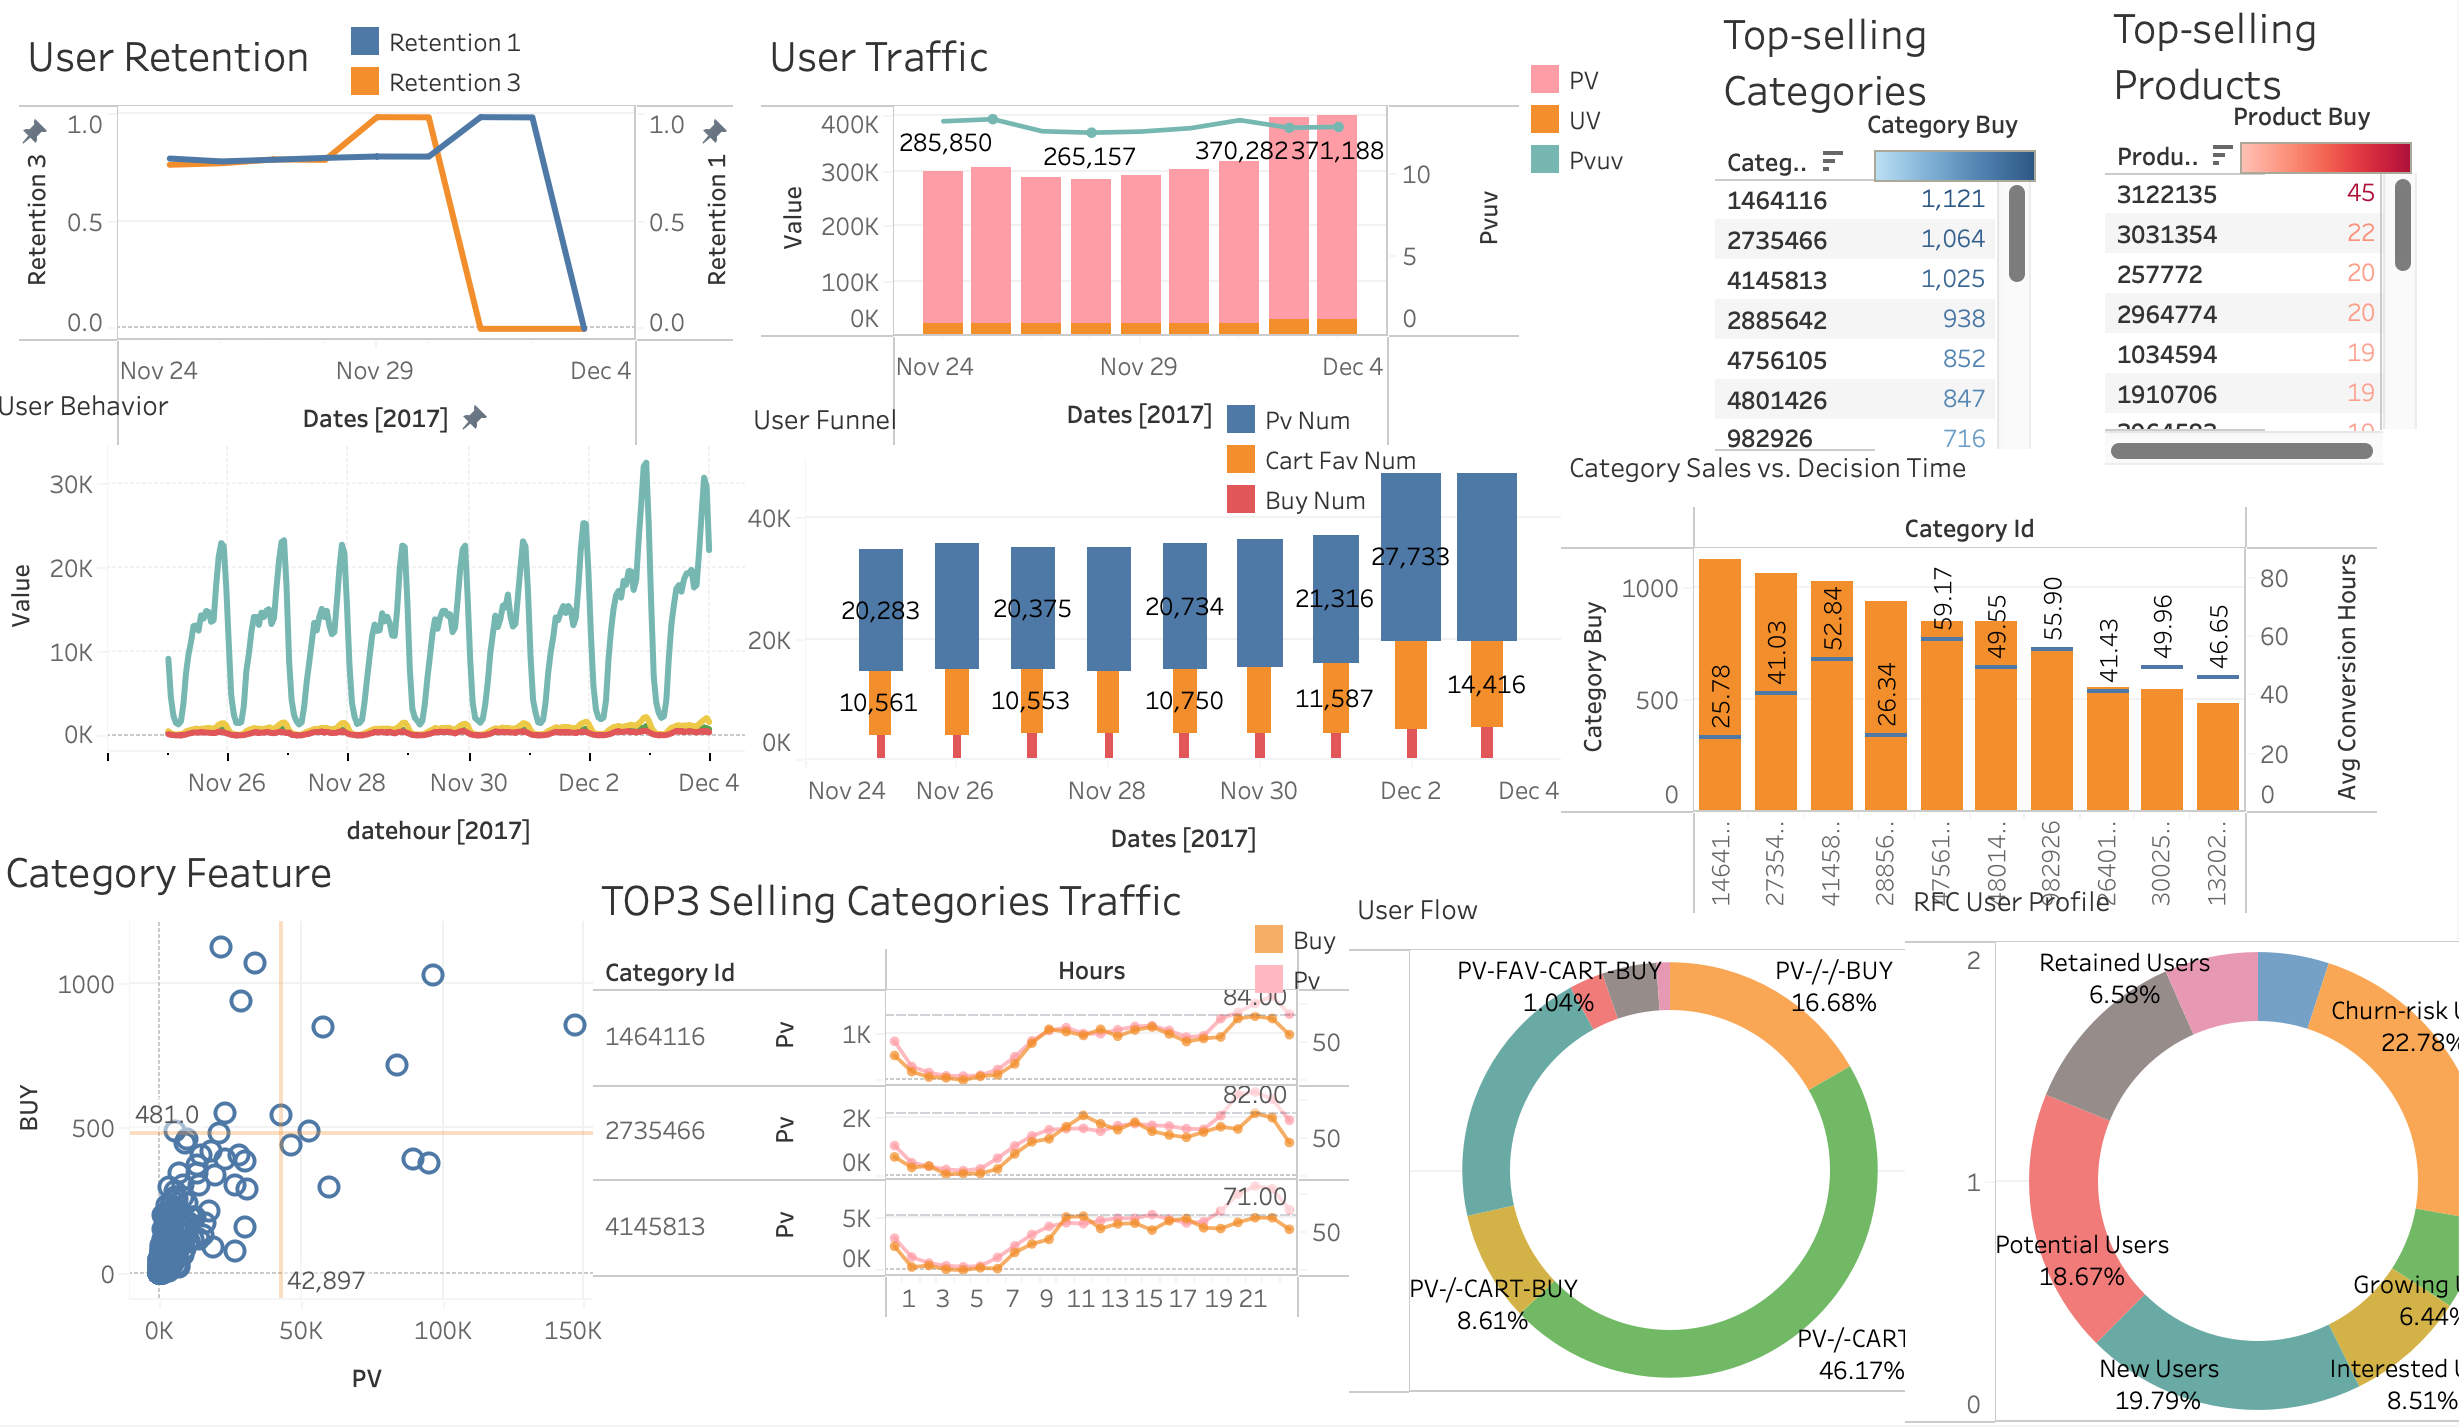

Dashborad Link:
https://public.tableau.com/app/profile/yue.hu8512/viz/1_17559239243320/1_1

# Report Intepretation
The analysis covers data from November 25 to December 3, during which November 25–26 and December 2–3 were weekends.

## User Retention Analysis
The chart illustrates the trends of one-day retention (Retention 1) and three-day retention (Retention 3) over this period.


Notably, Retention 1 shows a significant increase on December 1–2, while Retention 3 rises markedly on November 29–30.
Both indicators follow a similar upward trend, primarily driven by two key factors:

* Weekend effect: Users had more leisure time, leading to higher revisit and engagement rates after browsing.

* Pre-“Double 12” promotion effect: The upcoming shopping festival generated strong user interest through marketing campaigns, discounts, and promotional content, effectively reactivating users and boosting retention performance.

## User Traffic Overview
The traffic chart begins on a Saturday and covers the observation period from November 25 to December 3.
The data show that page views (PV) remain relatively stable during weekdays, while weekends (November 25–26 and December 2–3) exhibit noticeably higher browsing activity, reflecting increased shopping demand during users’ leisure time.

Both unique visitors (UV) and page views (PV) peak on December 2–3, which likely corresponds to the platform’s “Double 12” pre-sale and promotional campaigns. These marketing efforts effectively drove user traffic through increased exposure and engagement.

The average browsing depth (PV/UV) tends to be higher on weekends, as users spend more time exploring products. However, during the “Double 12” campaign, the metric decreases slightly due to the influx of new visitors attracted by the promotion, which diluted the average browsing depth.

## User Behavior Timeline

The temporal patterns of user behaviors show high synchronization across actions. The time series for favorites (FAV), add-to-cart (CART), and purchase (BUY) exhibit highly consistent fluctuations, sharing similar peaks and troughs throughout the day.

Two clear activity peaks emerge daily:

* 10:00–16:00 — the daytime browsing and engagement period

* 19:00–23:00, especially 20:00–22:00, representing the daily traffic peak

This pattern suggests that users tend to engage in shopping activities during work breaks and more actively after work hours, particularly in the evening leisure period.
From an operational perspective, this indicates that marketing campaigns, flash sales, and push notifications are likely to achieve the best performance when scheduled during 20:00–22:00, aligning with users’ highest activity levels.

## User Flow Analysis
The user journey reveals diverse behavioral paths, with a high proportion of direct browsing-to-purchase conversions, while significant drop-offs occur during the intention-to-action phase.

Excluding users who only browsed without further actions, the purchase paths exhibit considerable variation. Among all valid purchase routes, the top four by proportion are:

PV → BUY (16.7%)

PV → CART → BUY (8.6%)

PV → FAV → BUY (2.7%)

PV → FAV → CART → BUY (1.0%)

These patterns indicate that most users show strong browsing intent but limited conversion after expressing interest (via “Favorite” or “Add to Cart”). The substantial attrition between intention and transaction highlights conversion leakage in the mid-funnel stage.

From a strategic perspective, this suggests that personalized remarketing, discount nudges, and cart reminder mechanisms could effectively re-engage high-intent users and improve overall purchase conversion.

## Funnel Conversion Analysis
The funnel model shows that the overall conversion rate (PV → BUY) fluctuates between 2.0% and 2.5%, which should be interpreted in the context of industry benchmarks, platform stage, and historical data to determine whether it is within a healthy range.

Conversion rates are higher on weekdays, while weekends and the “Double 12” campaign period see larger traffic but lower conversion efficiency. This pattern likely reflects traffic quality differences—such as users browsing casually during weekends or adding items to carts for later purchase—and operational factors, including longer campaign funnels and more complex discount mechanisms during promotional events.

Overall, while the platform effectively drives traffic peaks during promotions, optimizing user flow from intention to purchase and simplifying the promotional journey could improve the conversion yield of high-traffic periods.

## User Profiling (RFC Model)
Due to the absence of transaction amount data, the traditional RFM model was modified into an RFC model, where:

R (Recency) represents the most recent purchase date,

F (Frequency) represents purchase frequency,

C (Cart & Fav) represents user engagement through adding to cart or favorites.


### Key Findings

* The main user base (62%) consists of Churn-Risk (23%), New (20%), and Potential Users (19%), reflecting a user structure dominated by low- to mid-value segments.

* Premium Users (12%) are the core profit contributors, with strong purchase and engagement behaviors.

* The high proportion of Churn-Risk Users (23%) indicates a large pool of dormant users; low-cost reactivation campaigns are recommended.

* Active Users (5%) are relatively few, suggesting insufficient recent repurchase among loyal users.

* New Users (20%) should be guided to increase purchase frequency through post-first-purchase engagement.

* Potential Users (19%) show strong purchase frequency but weak interest, implying potential for personalized recommendations to stimulate engagement.

* Interested Users (9%) have high interaction but low conversion — suitable for discount-driven promotions.



## Category Analysis
The platform hosts over 800,000 products across nearly 7,000 categories, showing significant variation in category-level performance.
Given the highly dispersed individual data (e.g., sales and views), the analysis focuses on top-performing categories.

By selecting the Top 23 products and categories based on purchase volume, we observe that traffic and sales vary more significantly across categories than across individual products.
Considering the large total product base and limited information on product or category names, subsequent analyses focus on category-level insights, emphasizing the behavioral and conversion characteristics of popular categories.

## Category Decision Time Analysis

Although the specific category names are unavailable, we can infer that categories with longer decision times likely represent high-consideration products such as furniture or electronics, where consumers deliberate before purchasing.
Conversely, categories with shorter decision times are likely impulse or necessity products, such as apparel or daily essentials like tissues.

By examining the relationship between average browsing-to-purchase time and sales volume, a negative correlation is observed — categories with shorter decision times tend to achieve higher sales.
This suggests that to improve conversion within limited decision windows, the platform could simplify the purchase process or optimize in-app decision aids (e.g., product recommendations, trust indicators, or streamlined checkout).

## Top 3 Best-Selling Categories Traffic Analysis
The traffic patterns of the Top 3 best-selling categories align closely with overall user activity peaks (10:00–16:00 and 19:00–23:00, especially 20:00–22:00), confirming the general applicability of current time-based operational strategies. However, it also reveals intense intra-category competition within these overlapping time windows.

Category 4145813 shows a significantly higher browsing volume compared to others, yet its sales performance does not scale proportionally, indicating possible weaknesses in the product detail page conversion or price competitiveness. This category warrants deeper inspection and optimization along the conversion path.

Additionally, both Category 4145813 and Category 2735466 record their sales peaks at 11:00 and 21:00. However, the browsing volume at 11:00 is only half that of 21:00. This suggests that purchases at 11:00 likely come from returning or loyal users who rely on prior knowledge and purchase habits, while visitors at 21:00 are more likely new or hesitant users, requiring more information and engagement before converting. The two groups exhibit distinct behavioral characteristics with minimal overlap.
### Business Insights
1. Enhance Conversion for High-Exposure Categories
For categories such as 4145813, which attract large browsing volumes but limited sales uplift, focus on optimizing the conversion path — refine product detail pages, highlight key differentiators (e.g., price, reviews, delivery speed), and reduce checkout friction.

2. Differentiate Strategies for New vs. Returning Users
Since 21:00 traffic is dominated by new or undecided users, prioritize informational content and trust-building (e.g., detailed product videos, user testimonials).
Conversely, during 11:00, when returning users are more active, deploy personalized quick-buy recommendations or loyalty offers to encourage fast repeat purchases.

3. Stagger Promotions to Avoid Category Overlap
Given the simultaneous traffic peaks across top categories, consider time-segmented or category-specific promotions to reduce direct competition during prime hours, improving overall conversion efficiency and ad ROI.


## Category Feature Analysis
By plotting page views (PV) on the x-axis and sales (BUY) on the y-axis, with the mean PV (42,897) and mean BUY (481) as quadrant boundaries, categories can be classified into four types:

Bestselling Categories (High PV, High BUY – Quadrant I):

High traffic and strong conversion, reflecting high user recognition and rigid demand.

Typically fast-moving consumer goods, e.g., tissues, laundry detergent.

High-Potential Categories (High PV, Low BUY – Quadrant II):

Large traffic but weak conversion; decision cost is high or demand is pseudo-high-frequency.

Often high-priced durable goods, e.g., home appliances, jewelry.

Niche Categories (Low PV, High BUY – Quadrant IV):

Low traffic but strong conversion; relies on precise demand or repeat loyal customers.

Examples include professional necessities, e.g., office supplies, industrial parts.

Declining Categories (Low PV, Low BUY – Quadrant III):

Both traffic and demand are weak; products may be homogeneous or obsolete.

Typical examples: outdated phones, niche handicrafts.

Lifecycle Dynamics:
The same category may traverse different quadrants over time. For instance, foldable smartphones may start in Quadrant II (curiosity-driven high PV, high price → low BUY), move to Quadrant I as they mature (high PV, high BUY), and eventually decline to Quadrant III as product features become outdated (low PV, low BUY).

This quadrant-based classification allows strategic focus on high-conversion and high-potential categories, while identifying niche or declining segments for optimization or divestment.

Author:SweetXT
